In [ ]:
!pip install transformers

In [70]:
import os
import sys
import requests
import subprocess

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from NLP_Reddit.distilbert_reddit.inference import inference
from NLP_Reddit.distilbert_reddit.models import DistilBertClassifier


sns.set(rc={'figure.figsize':(25, 8.5)})
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [70]:
#Expects kaggle.json on root dir
def backbone_download(delete_json=True):
  os.environ['KAGGLE_CONFIG_DIR'] = './'
  kaggle_out = subprocess.run(['kaggle', 'datasets', 'download', '-d', 'muniozdaniel0/final-distilbert-weight'], capture_output=True, text=True)
  unzip_out = subprocess.run(['unzip', './final-distilbert-weight.zip', '-d', './final-distilbert-weight'], capture_output=True, text=True)
  rm_out = subprocess.run(['rm', './final-distilbert-weight.zip'])

  print(kaggle_out.stdout[:-2])
  print(unzip_out.stdout[:-2])

  if delete_json:
    rm_out = subprocess.run(['rm', './kaggle.json'])


def fp_download():
  url = 'https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip'
  r = requests.get(url)
  with open('./FinancialPhraseBank-v10.zip', 'wb') as file:
    file.write(r.content)

  unzip_out = subprocess.run(['unzip', './FinancialPhraseBank-v10.zip', '-d', 'FinancialPhraseBank-v10'], capture_output=True, text=True)
  rm_out = subprocess.run(['rm', './FinancialPhraseBank-v10.zip'])
  print('Trying to access database... ', r)
  print(unzip_out.stdout[:-2])

#downloading data and weights
!kaggle datasets download -d muniozdaniel0/dogecoin-top-daily-reddit-submission
!unzip ./dogecoin-top-daily-reddit-submission.zip -d ./crypto-top-daily-reddit-submission
!rm ./dogecoin-top-daily-reddit-submission.zip

!kaggle datasets download -d muniozdaniel0/distilbert-reddit-financial-phrasebank-allagree
!unzip ./distilbert-reddit-financial-phrasebank-allagree.zip -d ./distilbert-reddit-fp-allagree-weights
!rm ./distilbert-reddit-financial-phrasebank-allagree.zip

backbone_download(delete_json=False)
fp_download()

In [70]:
#loading dataset and quick cleaning
btcoin_Dset = pd.read_csv('./crypto-top-daily-reddit-submission/Bitcoin_12htop100_DailySub_0101_to_0817_PushShift_raw.csv')
btcoin_Dset = btcoin_Dset.drop_duplicates('title')
btcoin_Dset = btcoin_Dset[(~btcoin_Dset['selftext'].duplicated()) | ((btcoin_Dset['selftext'].isnull())|(btcoin_Dset['selftext']=='[removed]'))] #removing duplicates except [NaN, removed]
btcoin_Dset = btcoin_Dset[~btcoin_Dset['subreddit'].str.contains('u_')]

#Title, score=2 and above only
btcoin_score = btcoin_Dset[btcoin_Dset['score']>1][['date', 'title']]

In [70]:
#loading model and weights
model = DistilBertClassifier(out_dim=3).to(device)
weights = torch.load('./distilbert-reddit-fp-allagree-weights/Distilbert_reddit_financial_phrasebank_10_epochs.pt',
                     map_location=device)
model.load_state_dict(weights['model_state_dict'])

#performing inference on the titles of the bitcoin dataset
btcoin_score = inference(model, btcoin_score, column='title', device=device)
btcoin_score['date'] = btcoin_score['date'].str[5:] #ignoring year
btcoin_score.to_csv('bitcoin_predictions_score_2.csv', index=False)

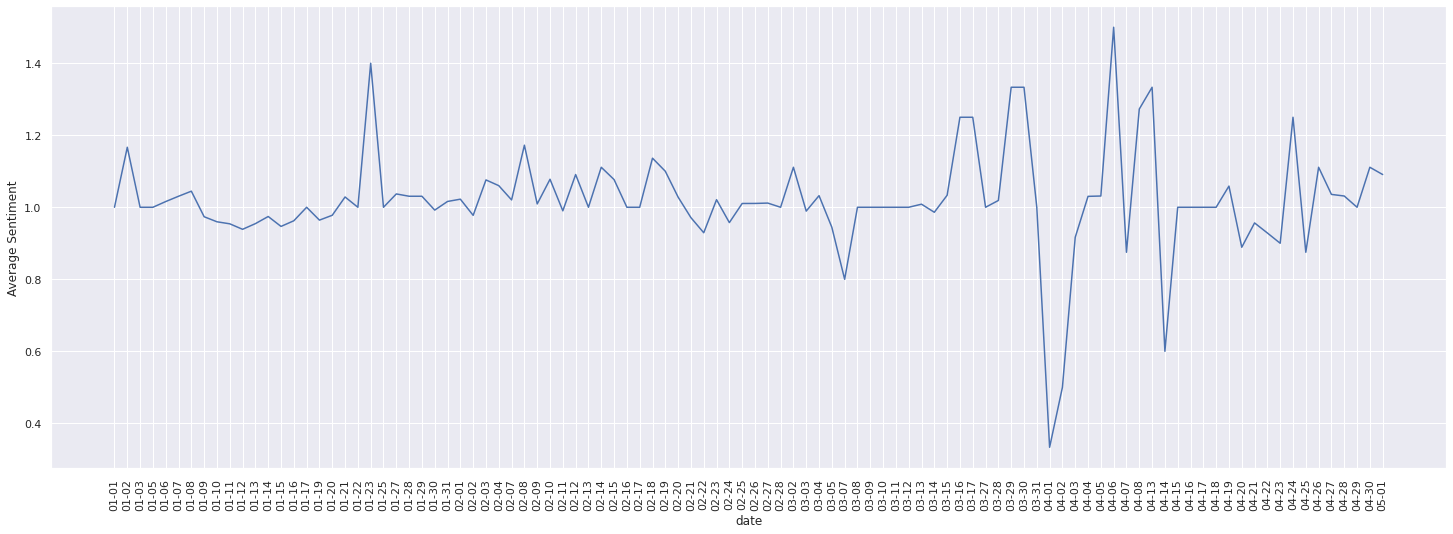

In [71]:
#Averaging sentiment on the available dates from 01-01 to 05-01
mean_preds = btcoin_score.groupby('date')['predictions'].mean()[:100]

plt.xticks(rotation=90)
plt.ylabel('Average Sentiment')
sns.lineplot(x=mean_preds.index, y=mean_preds.values)
plt.show()

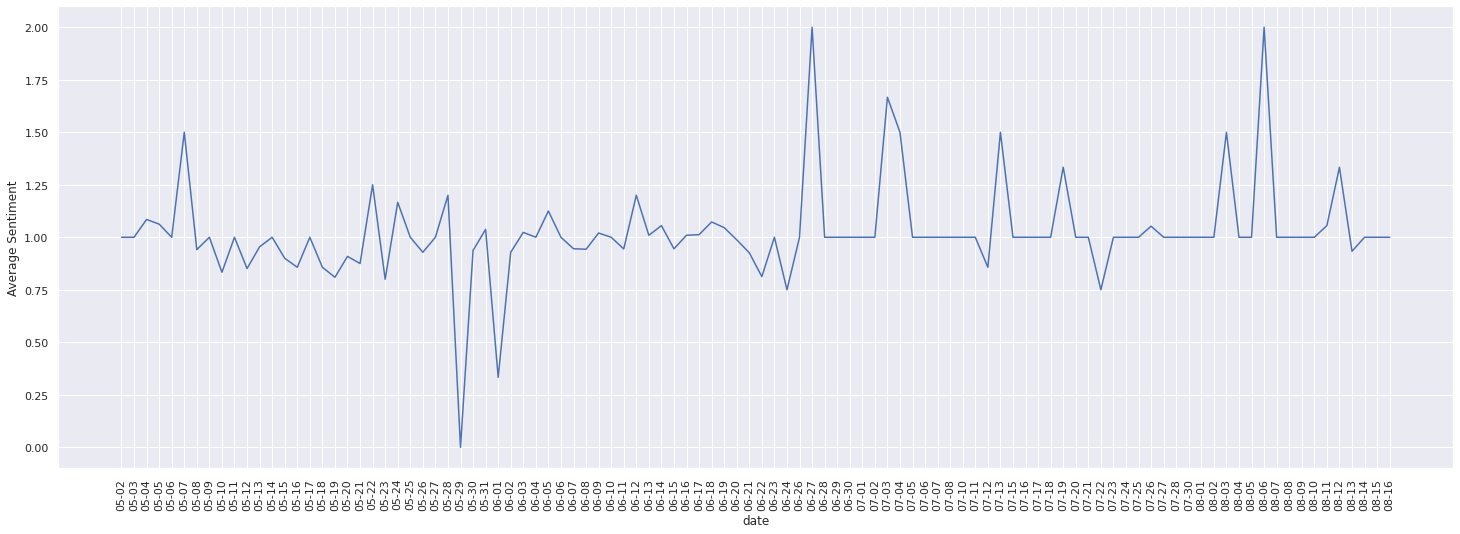

In [72]:
#Averaging sentiment on the available dates from 05-02 to 08-16
mean_preds = btcoin_score.groupby('date')['predictions'].mean()[100:]

plt.xticks(rotation=90)
plt.ylabel('Average Sentiment')
sns.lineplot(x=mean_preds.index, y=mean_preds.values)
plt.show()